# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Импортируем все необдходимое

In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

def describe(X: pd.Datadf, y: pd. Series):
    X_copy = X.copy()
    X_copy["is_ultra"] = y
    return X_copy.describe()


RANDOM_SEED = 42

AttributeError: module 'pandas' has no attribute 'Datadf'

##  Откроем и изучим файл

In [ ]:
df = pd.read_csv('datasets/users_behavior.csv')

In [ ]:
df.head()

### Проверим типы данных

In [ ]:
df.info()

In [ ]:
df.describe().T

#### Результаты проверки 
Оптимизируем типы данных

In [57]:
df['messages']=df['messages'].astype("int16")
df['calls']=df['calls'].astype("int16")
df['minutes']=df['minutes'].astype("int16")
df['mb_used']=df['mb_used'].astype("float32")
df['is_ultra']=df['is_ultra'].astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   calls     3214 non-null   int16   
 1   minutes   3214 non-null   int16   
 2   messages  3214 non-null   int16   
 3   mb_used   3214 non-null   float32 
 4   is_ultra  3214 non-null   category
dtypes: category(1), float32(1), int16(3)
memory usage: 34.8 KB


In [59]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
calls,3214.0,63.038892,33.236368,0.0,40.0,62.0,82.00,244.0
minutes,3214.0,437.717797,234.559661,0.0,274.0,430.0,571.75,1632.0
messages,3214.0,38.281269,36.148326,0.0,9.0,30.0,57.00,224.0
mb_used,3214.0,17207.537109,7570.869629,0.0,12490.0,16944.0,21424.00,49760.0


### Проверим  дубликаты

In [ ]:
df.duplicated().sum()

#### Результаты проверки 
Дубликатов не найдено

### Проверка на корректность наименований столбцов

In [60]:
df.columns

Index(['calls', 'minutes', 'messages', 'mb_used', 'is_ultra'], dtype='object')

#### Результаты проверки 
Имена столбцов заданы корректно

### Проверим значения содержащиеся в столбцах

In [49]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
calls,3214.0,63.038892,33.236368,0.0,40.0000,62.000,82.00,244.00
minutes,3214.0,437.717797,234.559661,0.0,274.0000,430.000,571.75,1632.00
messages,3214.0,38.281269,36.148326,0.0,9.0000,30.000,57.00,224.00
mb_used,3214.0,17207.673836,7570.968246,0.0,12491.9025,16943.235,21424.70,49745.73


### Вывод

1. Пропущенных значений нет
1. Типы столбцов в порядке
1. Дубликатов нет
2. Датафрейм не сбалансирован. Позже, надо будет произвести балансировку обучающей выборки с помощью imbalanced-learn

# Разобьем данные на выборки

Разделим данные на целевой столбец и матрицу признаков

In [28]:
X = df.copy()
X = X.drop(columns=["is_ultra"])
y = df["is_ultra"]

Так как у нас нет скрытой тестовой выборки - сделаем свою

In [29]:
(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(X,
                            y,
                            test_size = 0.33,
                            random_state = RANDOM_SEED
                                       )


Проведем балансировку

In [30]:
# На случай, если балансировка не применяется
X_balanced = X_train
y_balanced = y_train

In [31]:
over = RandomOverSampler(sampling_strategy=1)
X_balanced, y_balanced = over.fit_resample(X_train, y_train)
# under = RandomUnderSampler(sampling_strategy=0.7)
# X, y = under.fit_resample(X, y)

Проведем иследование сформированной выборки

In [32]:
describe(X_balanced, y_balanced)

,calls,minutes,messages,mb_used
count,3004.000000,3004.000000,3004.000000,3004.000000
mean,66.543609,462.347537,41.599201,17592.118615
std,37.107943,261.905455,40.101094,8301.376894
min,0.000000,0.000000,0.000000,0.000000
25%,41.000000,278.000000,9.000000,12048.607500
50%,66.000000,448.000000,32.000000,17135.400000
75%,88.000000,614.250000,62.000000,22173.307500
max,203.000000,1566.000000,224.000000,49745.730000


Сравним с обучающей выборкой

In [33]:
describe(X_train, y_train)

,calls,minutes,messages,mb_used
count,2153.000000,2153.000000,2153.000000,2153.000000
mean,63.569438,441.437065,38.439387,17088.302411
std,33.207525,234.708017,36.468135,7426.242514
min,0.000000,0.000000,0.000000,0.000000
25%,41.000000,279.000000,9.000000,12388.400000
50%,63.000000,432.000000,30.000000,16835.990000
75%,83.000000,578.000000,57.000000,21289.280000
max,203.000000,1566.000000,224.000000,49745.730000


Теперь разделим тестовую выборку на тестовую и валидационную

In [34]:
(X_valid,
 X_test,
 y_valid,
 y_test) = train_test_split(X_test,
                            y_test,
                            test_size = 0.5,
                            random_state = RANDOM_SEED
                                       )

#  Исследуем модели

## Random Forest

Поиск лучшего классификатора по точности предсказания и по матрице ошибок

In [35]:
best_RF = None
best_accuracy_RF = 0
best_est_RF = 0
best_depth_RF = 0
exit = False
est = 5
TARGET = (0, 0) # Ищем то, что приведет к меньшему числу ложных рекомендаций Смарт. Этот параметр в матрице должен быть минимальных среди моделей
min_target = len(X_valid)
parameters = []
for est in tqdm(range(1,33)):
    for depth in range(2, 10):
        RF = RandomForestClassifier(random_state = RANDOM_SEED,n_estimators = est, max_depth = depth)
        RF.fit(X_balanced, y_balanced)
        prediction_valid_RF = RF.predict(X_valid)
        cm = confusion_matrix(prediction_valid_RF, y_valid)
        accuracy_RF = accuracy_score(prediction_valid_RF, y_valid)
        if cm[TARGET[0]][TARGET[1]] < min_target:
            min_target = cm[TARGET[0]][TARGET[1]]
            best_RF_on_cm = RF
            best_accuracy_RF_on_cm = accuracy_RF
        
        parameters.append((est, depth, accuracy_RF))
        if best_accuracy_RF < accuracy_RF:
            best_RF = RF
            best_depth_RF = depth
            best_est_RF = est
            best_accuracy_RF = accuracy_RF
print(best_RF, best_RF_on_cm)
            

100%|██████████████████████████████████████████| 32/32 [00:42<00:00,  1.34s/it]

RandomForestClassifier(max_depth=9, n_estimators=19, random_state=42) RandomForestClassifier(max_depth=4, n_estimators=3, random_state=42)


Для ускорения повторного обращения к блокноту создадим лес по лучшим параметрам для сбалансированной обучающей выборки (33, 4)
Для несбалансированной выборки лучшая точность достигается при 4, 4


In [36]:
# best_RF = RandomForestClassifier(random_state = RANDOM_SEED,n_estimators = 33, max_depth = 4)
# best_RF.fit(X_balanced, y_balanced)
# prediction_valid_RF = best_RF.predict(X_valid)
# best_accuracy_RF = accuracy_score(prediction_valid_RF, y_valid)

## Decision Tree

In [37]:
best_DT = None
best_accuracy_DT = 0
best_depth_DT = 0
for depth in tqdm(range(2,20)):
    DT = DecisionTreeClassifier(random_state = RANDOM_SEED, max_depth = depth)
    DT.fit(X_balanced, y_balanced)
    prediction_valid_DT = DT.predict(X_valid)
    accuracy_DT = accuracy_score(prediction_valid_DT, y_valid)
    if best_accuracy_DT < accuracy_DT:
        best_DT = DT
        best_accuracy_DT = accuracy_DT
        best_depth_DT = depth

100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 34.59it/s]


Лучшая модель Decision tree


## LogisticRegression

In [38]:
LR = LogisticRegression(random_state = RANDOM_SEED,max_iter= 1000,tol=1e-5,solver = 'lbfgs' )
LR.fit(X_train, y_train)
prediction_valid_LR = LR.predict(X_valid)
accuracy_LR = accuracy_score(prediction_valid_LR, y_valid)

In [39]:
print(f"Logistic Regression: {accuracy_LR}")
print(f"Random Forest: {best_accuracy_RF}")
print(f"Random Forest on CM: {best_accuracy_RF_on_cm}")
print(f"Decision Tree: {best_accuracy_DT}")

Logistic Regression: 0.7226415094339622
Random Forest: 0.8056603773584906
Random Forest on CM: 0.7358490566037735
Decision Tree: 0.7886792452830189


## Вывод 

Основываясь на показателе точности, можно  прийти к выводу, что наиболее качественные результаты прогнозирует Random Forest

# Проверьте модель на тестовой выборке

In [40]:
prediction_test_LR = LR.predict(X_test)
prediction_test_RF = best_RF.predict(X_test)
prediction_test_RF_on_cm = best_RF_on_cm.predict(X_test)
prediction_test_DT = best_DT.predict(X_test)

In [41]:
accuracy_LR_test = accuracy_score(prediction_test_LR, y_test)
accuracy_RF_test = accuracy_score(prediction_test_RF, y_test)
accuracy_RF_test_on_cm = accuracy_score(prediction_test_RF_on_cm, y_test)
accuracy_DT_test = accuracy_score(prediction_test_DT, y_test)

In [42]:
print(f"Logistic Regression:\t {accuracy_LR_test}")
print(f"Random Forest:\t {accuracy_RF_test}")
print(f"Random Forest on confusion matrix:\t {accuracy_RF_test_on_cm}")
print(f"Decision Tree:\t {accuracy_DT_test}")

Logistic Regression:	 0.7608286252354048
Random Forest:	 0.8060263653483992
Random Forest on confusion matrix:	 0.7702448210922788
Decision Tree:	 0.7740112994350282


In [43]:
# Чтобы видеть - балансированная выборка или нет - участвовала в обучении
describe(X_balanced, y_balanced)

,calls,minutes,messages,mb_used
count,3004.000000,3004.000000,3004.000000,3004.000000
mean,66.543609,462.347537,41.599201,17592.118615
std,37.107943,261.905455,40.101094,8301.376894
min,0.000000,0.000000,0.000000,0.000000
25%,41.000000,278.000000,9.000000,12048.607500
50%,66.000000,448.000000,32.000000,17135.400000
75%,88.000000,614.250000,62.000000,22173.307500
max,203.000000,1566.000000,224.000000,49745.730000


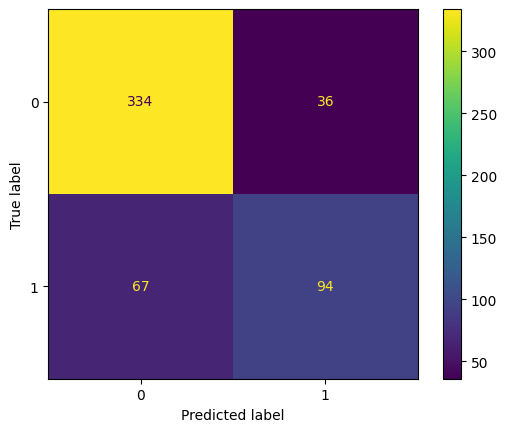

In [44]:
disp = ConfusionMatrixDisplay.from_estimator(best_RF, X_test, y_test)

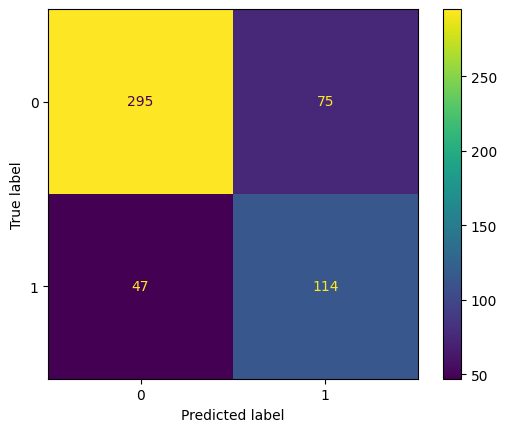

In [45]:
disp = ConfusionMatrixDisplay.from_estimator(best_RF_on_cm, X_test, y_test)

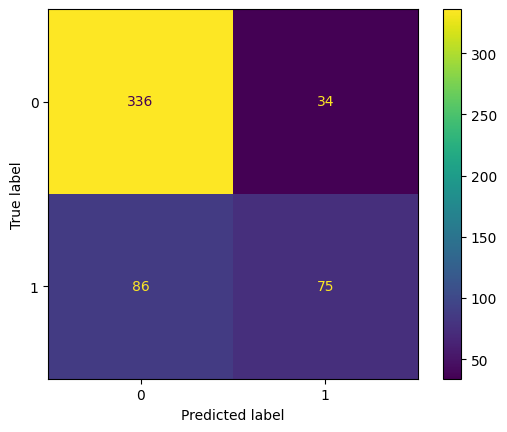

In [46]:
disp = ConfusionMatrixDisplay.from_estimator(best_DT, X_test, y_test)

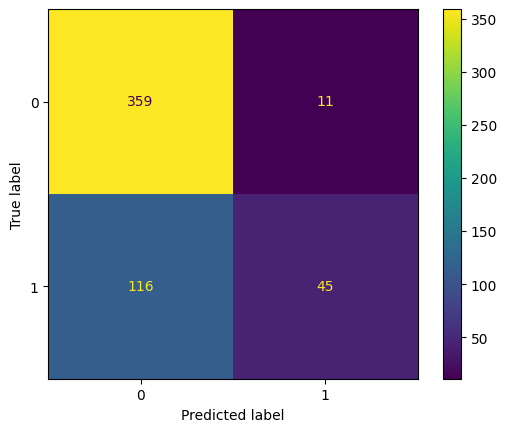

In [47]:
disp = ConfusionMatrixDisplay.from_estimator(LR, X_test, y_test)

## Вывод

Результаты на тестовой выборке

* Logistic Regression:	 0.7368421052631579
* Random Forest:	 0.7744360902255639
* Random Forest on confusion matrix:	 0.7368421052631579
* Decision Tree:	 0.7593984962406015

Лес и дерево показали неплохие результаты. При этом, на валидационной выборке результаты в некоторых итерациях достигали 86% точности. Это говорит о недостаточности данных для обучения модели для более высокой точности, что очевидно и без результатов сравнения.

Валидация успешности модели может осуществляться различными методами. Например, для леса был добавлен критерий - количество ложных рекомендаций трифа Смарт должно быть минимально. Такая модель имеет сниженную точность предсказаний, но в руках маркетологов позволила бы достичь большей прибыли, но это не точно.

*** Конец ознакомительного фрагмента. Для более точного аудита мы готовы произвести для вас более обширное исследование, результаты которого помогут вам извлечь максимум прибыли из вашего бизнеса.